<a href="https://colab.research.google.com/github/godmin18/project/blob/master/mecab%2BGRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# https://ebbnflow.tistory.com/246
# https://wikidocs.net/94600

In [1]:
import os, sys 
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [ ]:
import torch
import torchvision
import torch.nn
torch.cuda.is_available()

True

In [ ]:
# Colab에 Mecab 설치
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh > /dev/null

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 109, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 109 (delta 7), reused 10 (delta 3), pack-reused 91
Receiving objects: 100% (109/109), 1.27 MiB | 9.29 MiB/s, done.
Resolving deltas: 100% (46/46), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
     |████████████████████████████████| 19.4 MB 1.3 MB/s 
     |████████████████████████████████| 448 kB 40.3 MB/s 
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2022-01-12 14:57:42--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::22e9:9f55, 2406:da00:ff00::22cd:e0db, ...
Connecting to bitbucket.org (bitbucket.org)|104.192.141.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Loca

In [ ]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
DIR = '/content/drive/MyDrive/project/영화 리뷰 감성 분석/dataset'
TRAIN_SOURCE = os.path.join(DIR, "train.csv")
TEST_SOURCE = os.path.join(DIR, "test.csv")
SAMPLE_SUBMISSION = os.path.join(DIR, "sample_submission.csv")

train = pd.read_csv(TRAIN_SOURCE)
test = pd.read_csv(TEST_SOURCE)
print("train row : {}, train col : {}".format(str(train.shape[0]), str(train.shape[1])))
print("test row : {}, test col : {}".format(str(test.shape[0]), str(test.shape[1])))

train row : 5000, train col : 3
test row : 5000, test col : 2


In [ ]:
train_x, train_y = train.iloc[:, :2], train.iloc[:, 2:3]
test_x = test

In [ ]:
# 문장 부호 치환
punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
punct_mapping = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", "×": "x", "²": "2", "—": "-", "–": "-", "’": "'", "_": "-", "`": "'", '“': '"', '”': '"', '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-', 'β': 'beta', '∅': '', '³': '3', 'π': 'pi', }

def clean_punc(text, punct, mapping):
    for key in mapping:
        text = text.replace(key, mapping[key])
    
    for p in punct:
        text = text.replace(p, f' {p} ')
    
    specials = {'\u200b': ' ', '…': ' ... ', '\ufeff': '', 'करना': '', 'है': ''}
    for s in specials:
        text = text.replace(s, specials[s])

    return text


In [ ]:
X_train = clean_punc(train_x['document'], punct, punct_mapping)
X_test = clean_punc(test_x['document'], punct, punct_mapping)

In [ ]:
# 전처리

def clean_text(review): 
  # corpus = [] 
  # for review in texts:
  review = re.sub(r'[@%\\*=()/~#&\+á?\xc3\xa1\-\|\.\:\;\!\-\,\_\~\$\'\"]', '', review) #remove punctuation 
  review = re.sub(r'\d+','', review)# remove number 
  review = review.lower() #lower case 
  review = re.sub(r'\s+', ' ', review) #remove extra space 
  review = re.sub(r'<[^>]+>','',review) #remove Html tags
  # review = re.sub(r'\s+', '', review) #remove spaces 
  review = re.sub(r"^\s+", '', review) #remove space from start 
  review = re.sub(r'\s+$', '', review) #remove space from the end 
  # corpus.append(review) 
  return review

In [ ]:
X_train = X_train.apply(clean_text)
X_test = X_test.apply(clean_text)

In [ ]:
# 불용어 제거

stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

#불용어 제거
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stopwords:
            final_text.append(i.strip())
    return " ".join(final_text)

In [ ]:
X_train = X_train.apply(remove_stopwords)
X_test = X_test.apply(remove_stopwords)

In [ ]:
mecab = Mecab()

In [ ]:
X_train = X_train.apply(mecab.morphs)
X_test = X_test.apply(mecab.morphs)

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 7316
등장 빈도가 1번 이하인 희귀 단어의 수: 4219
단어 집합에서 희귀 단어의 비율: 57.66812465828322
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.814180731648227


In [ ]:
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 3099


In [ ]:
# vocab 사전에 없는 단어는 oov로 지정하여 1이라는 숫자를 부여
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

리뷰의 최대 길이 : 30
리뷰의 평균 길이 : 12.383


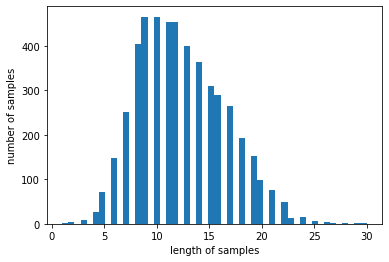

In [ ]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [ ]:
max_len = 28
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 28 이하인 샘플의 비율: 99.96000000000001


In [ ]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(GRU(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, train_y, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
62/63 [============================>.] - ETA: 0s - loss: 0.5082 - acc: 0.7603
Epoch 00001: val_acc improved from -inf to 0.82400, saving model to best_model.h5
63/63 [==============================] - 7s 25ms/step - loss: 0.5065 - acc: 0.7615 - val_loss: 0.3791 - val_acc: 0.8240
Epoch 2/15
60/63 [===========================>..] - ETA: 0s - loss: 0.2726 - acc: 0.8883
Epoch 00002: val_acc improved from 0.82400 to 0.85700, saving model to best_model.h5
63/63 [==============================] - 1s 16ms/step - loss: 0.2699 - acc: 0.8892 - val_loss: 0.3733 - val_acc: 0.8570
Epoch 3/15
60/63 [===========================>..] - ETA: 0s - loss: 0.2057 - acc: 0.9187
Epoch 00003: val_acc did not improve from 0.85700
63/63 [==============================] - 1s 14ms/step - loss: 0.2108 - acc: 0.9180 - val_loss: 0.3472 - val_acc: 0.8520
Epoch 4/15
62/63 [============================>.] - ETA: 0s - loss: 0.1629 - acc: 0.9357
Epoch 00004: val_acc did not improve from 0.85700
63/63 [==========

In [ ]:
loaded_model = load_model('best_model.h5')

In [ ]:
result = loaded_model.predict(X_test)

In [ ]:
sentiment = []
for i in range(0, len(result)):
  if result[i] > 0.5:
    sentiment.append('1')
  else:
    sentiment.append('0')

In [ ]:
sample_submission = pd.read_csv('/content/drive/MyDrive/project/영화 리뷰 감성 분석/dataset/sample_submission.csv')


In [ ]:
sample_submission['label'] = sentiment

In [ ]:
sample_submission

,id,label
0,1,0
1,2,1
2,3,0
3,4,1
4,5,1
...,...,...
4995,4996,0
4996,4997,0
4997,4998,1
4998,4999,0


In [ ]:
sample_submission.to_csv('/content/drive/MyDrive/project/영화 리뷰 감성 분석/etc/sample_submission_GRU.csv', index=False)